In [1]:
import os
import xarray as xr
import numpy as np 
from pathlib import Path
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset,DataLoader
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
from torch.optim import Adam 
from einops import rearrange
import tqdm

In [2]:
from denoising_diffusion_pytorch import Unet
from tc_data_loader import TC_xy_Dataset 
from tc_diff_guided import Diffusion_model, count_parameters

/home/cw55/.conda/envs/tcdiff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
timesteps = 300
batch_size = 8
results_folder = Path("./tc_guide_wvp")
os.makedirs(results_folder, exist_ok=True)
obs_ratio = 0.2

# Dataset

In [4]:
test_data  = TC_xy_Dataset(data_dir='./dataset/tc_data',
                               data_vars=['WVP'],
                               years=[126,127]) 

var WVP year 126: length 3724 
var WVP year 127: length 3521 


# Load the model 

In [5]:
# diffusion model
tc_diff_model = Diffusion_model(timesteps)

In [6]:
# decoder model
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = test_data.data.shape[-1]
channels = test_data.data.shape[1]

model = Unet(
    dim = 32,
    out_dim=channels,
    channels=channels*2, 
    dim_mults = (1,2,4), 
    resnet_block_groups = 4,
    flash_attn = False
)
model.to(device)
print('Total model parameter',count_parameters(model))
model.load_state_dict(torch.load(results_folder/'best_model.ckpt'))

Total model parameter 2611233


<All keys matched successfully>

# Sampling (inference)

In [7]:
# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    
    num_rows = len(imgs) 
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(12,4), dpi = 200, nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx] 
            ax.imshow(np.asarray(img),vmin=20, vmax=80,cmap='jet', **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, a0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()
    return fig

In [8]:
# sample 64 images
sample_batch_size = 256 
samples, target = tc_diff_model.sample(model, image_size=image_size, batch_size=sample_batch_size, 
                               channels=channels, obs_ratio=obs_ratio,
                               dataset=test_data)

sampling loop time step: 100%|██████████| 300/300 [03:39<00:00,  1.37it/s]


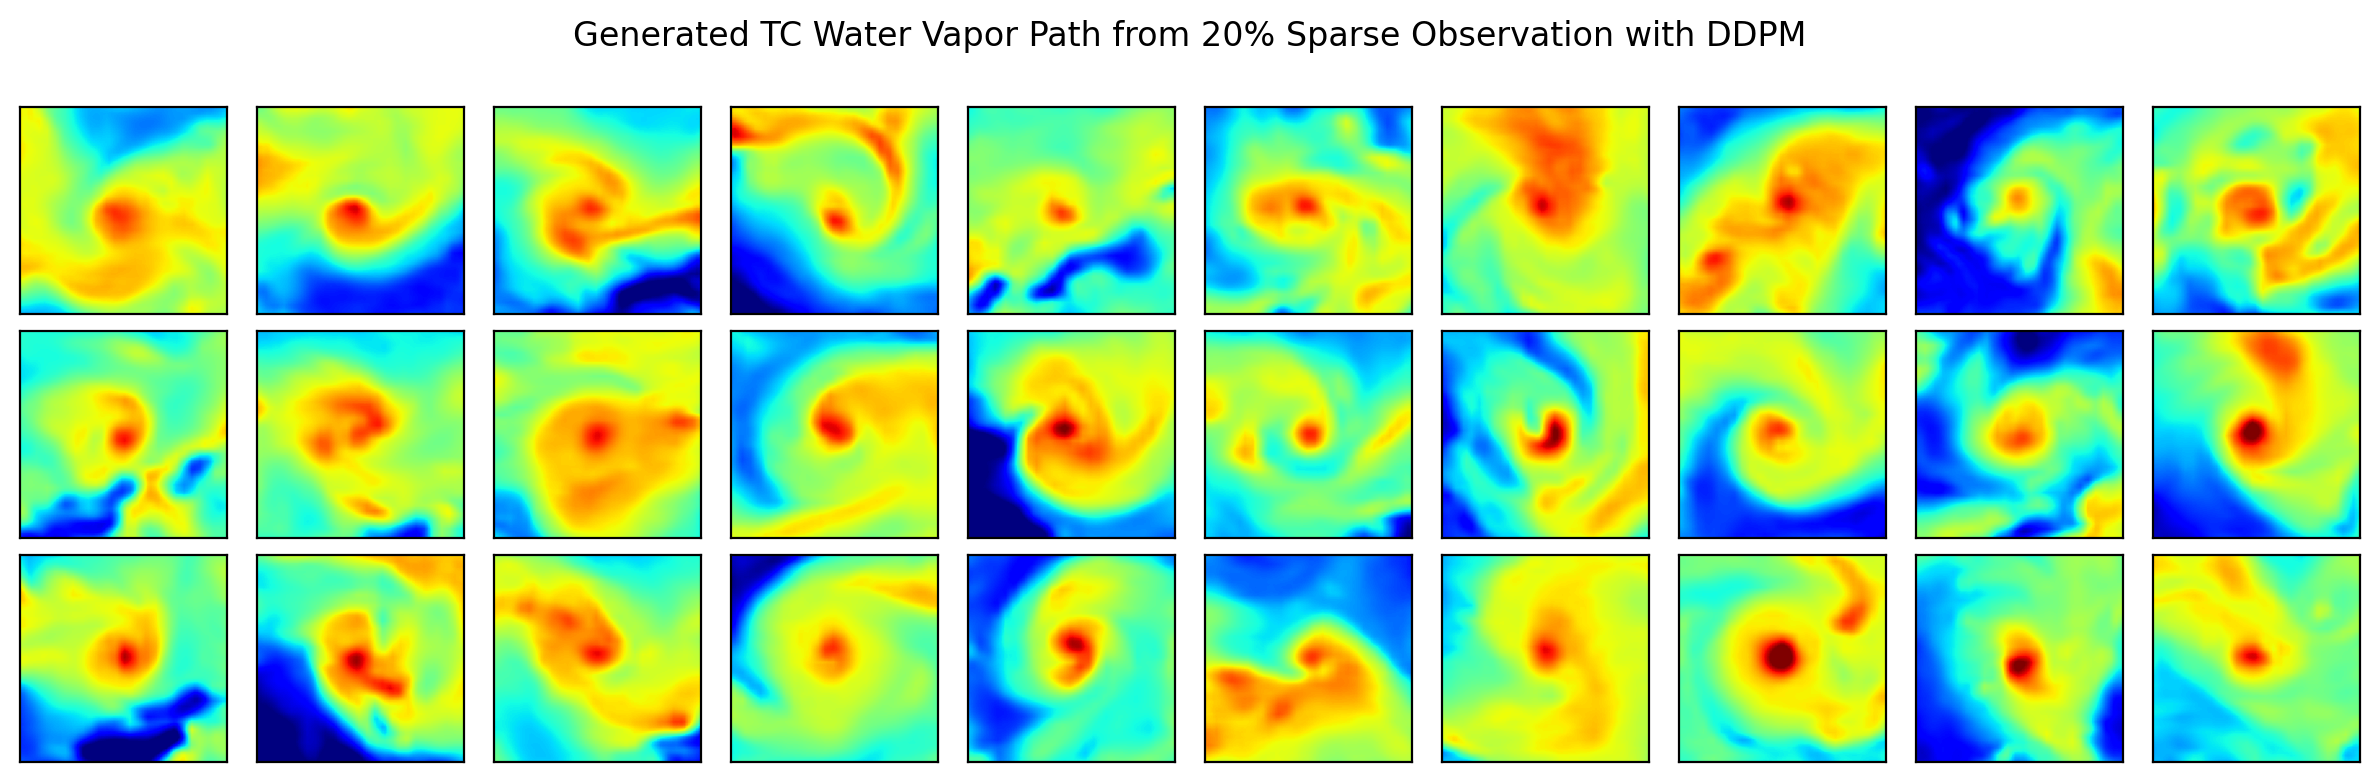

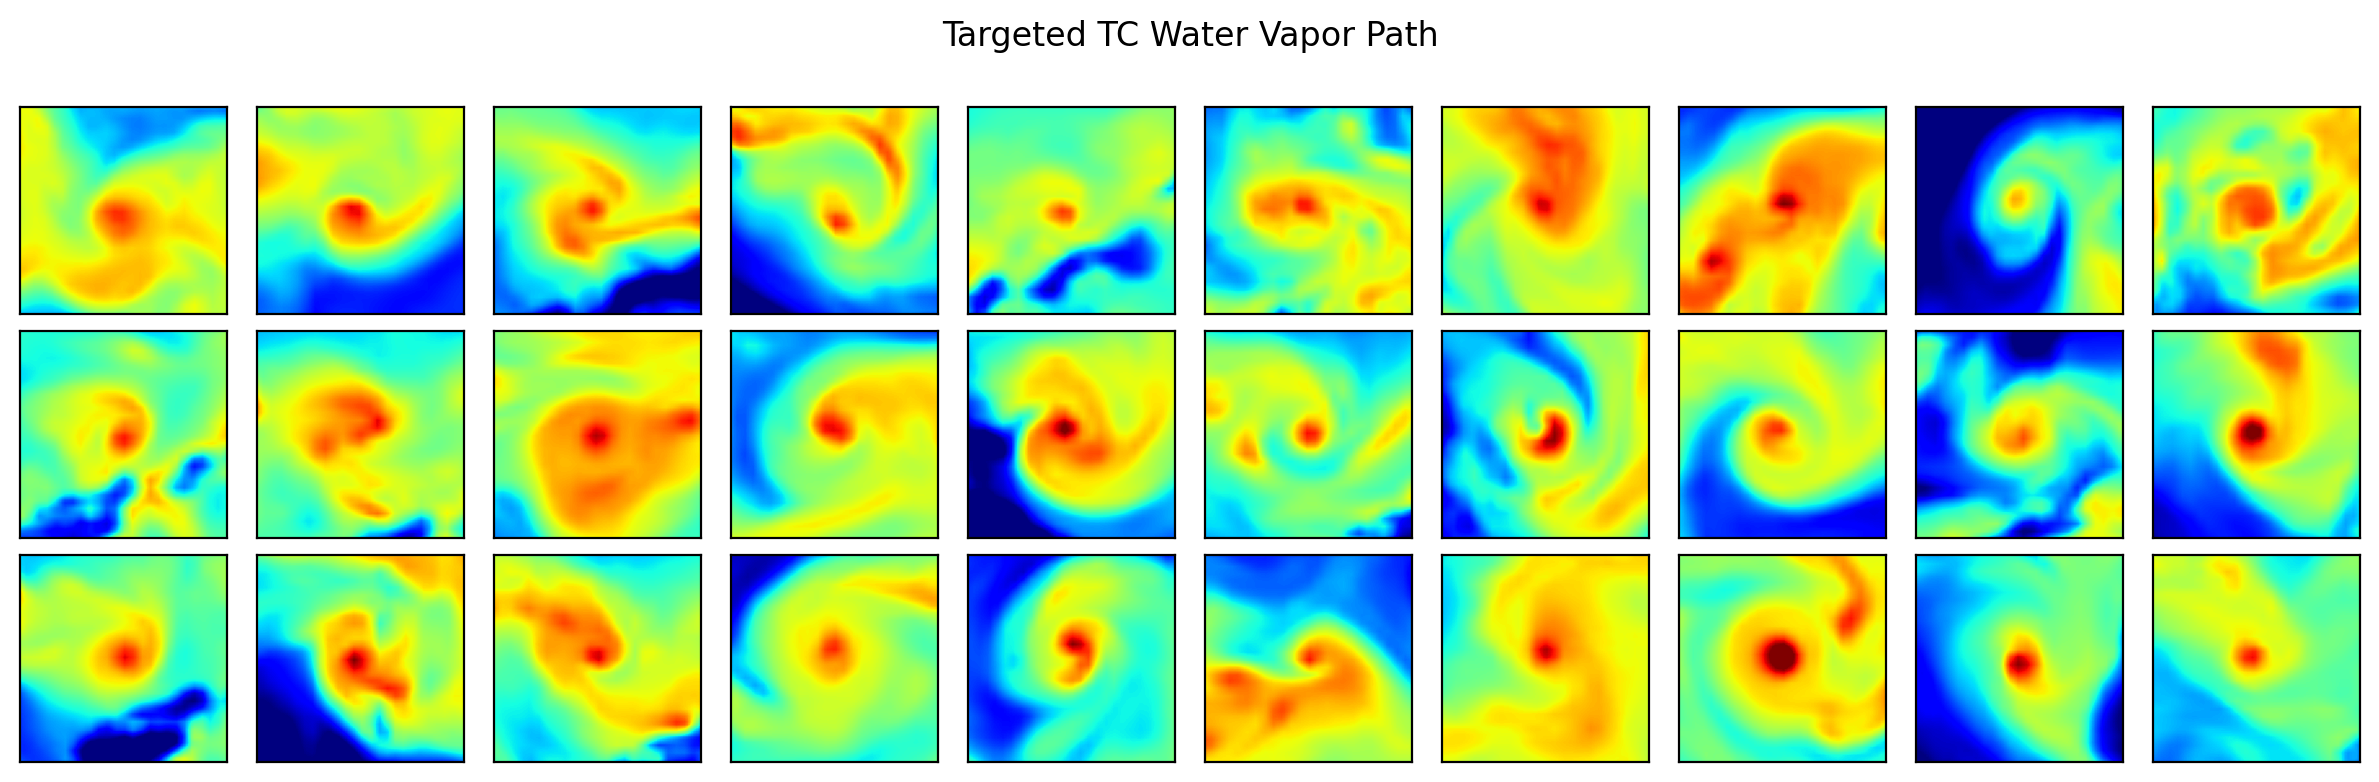

In [9]:
model_samples = [samples[-1][_] for _ in range(sample_batch_size)]
# unnorm
model_samples = test_data.unnormalization(np.array(model_samples))
model_samples_plot = rearrange(model_samples[:30], '(br bc) c h w -> br bc h w c', br=3)
fig = plot(model_samples_plot)
fig.suptitle(f"Generated TC Water Vapor Path from {obs_ratio*100:.0f}% Sparse Observation with DDPM")
plt.tight_layout()
plt.savefig('./tc_guide_wvp/generated.png')
# trainning data samples
target_samples = test_data.unnormalization(target)
target_samples_plot = rearrange(target_samples[:30], '(br bc) c h w -> br bc h w c', br=3)
fig = plot(target_samples_plot)
fig.suptitle(f"Targeted TC Water Vapor Path")
plt.tight_layout()
plt.savefig('./tc_guide_wvp/target.png')

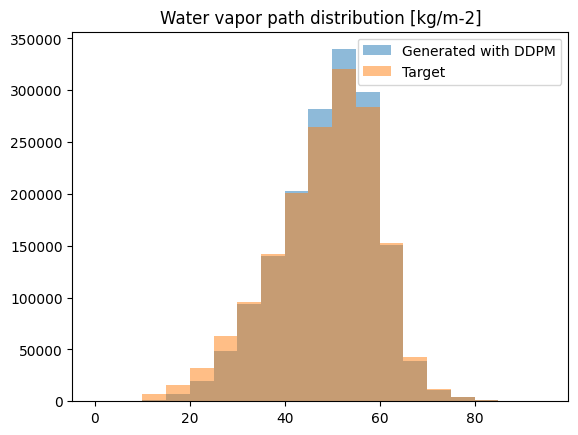

In [10]:
plt.hist(model_samples.flatten(),bins=np.arange(0,100,5),alpha=0.5,label='Generated with DDPM')
plt.hist(target_samples.flatten(),bins=np.arange(0,100,5),alpha=0.5,label='Target')
plt.title('Water vapor path distribution [kg/m-2]')
plt.legend()